In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
b_direct_insurance = pd.read_csv("/content/budget_direct_car_insuarance_reviews.csv")
racv_ins = pd.read_csv("/content/racv_car_insuarance_reviews.csv")
youi_ins = pd.read_csv("/content/youi_car_insuarance_reviews.csv")

In [ ]:
b_direct_insurance.columns

Index(['title', 'review', 'date', 'stars'], dtype='object')

In [ ]:
racv_ins.columns

Index(['title', 'review', 'date', 'stars'], dtype='object')

In [ ]:
youi_ins.columns

Index(['title', 'review', 'date', 'stars'], dtype='object')

In [ ]:
# Adding new flag column for all the data sets
b_direct_insurance['Brand'] = 'Budget Direct'
racv_ins['Brand'] = 'racv'
youi_ins['Brand'] = 'youi'

In [ ]:
b_direct_insurance.drop(['title', 'date'], axis=1, inplace=True)
racv_ins.drop(['title', 'date'], axis=1, inplace=True)
youi_ins.drop(['title', 'date'], axis=1, inplace=True)

***Data Preprocessing***

In [ ]:
#combining the datasets
c_reviews = pd.concat([b_direct_insurance,racv_ins,youi_ins], ignore_index=True)

In [ ]:
print(c_reviews.head())
print(c_reviews.tail())

                                              review  ...          Brand
0  Driver took a long time to arrive apparently d...  ...  Budget Direct
1  I can't count the number of calls I made, emai...  ...  Budget Direct
2  My claim took 3m+, they will find all possible...  ...  Budget Direct
3  Take it easy just call and get it event online...  ...  Budget Direct
4  Easy to use, professional service, definitely ...  ...  Budget Direct

[5 rows x 3 columns]
                                                 review             stars Brand
2387  I have just joined but im very happy already a...  1 out of 5 stars  youi
2388  never  new  last   ins 25yrs  so we are please...  5 out of 5 stars  youi
2389  Changed to Youi just under 12 months. Saved ap...  5 out of 5 stars  youi
2390  I have just now joined. No need for service or...  5 out of 5 stars  youi
2391  I have been with Youi now for approx. three ye...  5 out of 5 stars  youi


***Converting Stars to Completely Numeric***

In [ ]:
c_reviews['StarRatingNumeric'] = c_reviews.stars.apply(lambda r: int(float(r.split()[0])))

In [ ]:
c_reviews.head()

,review,stars,Brand,StarRatingNumeric
0,Driver took a long time to arrive apparently d...,2 out of 5 stars,Budget Direct,2
1,"I can't count the number of calls I made, emai...",1 out of 5 stars,Budget Direct,1
2,"My claim took 3m+, they will find all possible...",1 out of 5 stars,Budget Direct,1
3,Take it easy just call and get it event online...,5 out of 5 stars,Budget Direct,5
4,"Easy to use, professional service, definitely ...",5 out of 5 stars,Budget Direct,5


In [ ]:
c_reviews.drop(['stars'], axis=1, inplace=True)
c_reviews.head()

,review,Brand,StarRatingNumeric
0,Driver took a long time to arrive apparently d...,Budget Direct,2
1,"I can't count the number of calls I made, emai...",Budget Direct,1
2,"My claim took 3m+, they will find all possible...",Budget Direct,1
3,Take it easy just call and get it event online...,Budget Direct,5
4,"Easy to use, professional service, definitely ...",Budget Direct,5


In [ ]:
#converting the reviews to lowercase
c_reviews['review'] = c_reviews['review'].str.lower()
c_reviews.head()

,review,Brand,StarRatingNumeric
0,driver took a long time to arrive apparently d...,Budget Direct,2
1,"i can't count the number of calls i made, emai...",Budget Direct,1
2,"my claim took 3m+, they will find all possible...",Budget Direct,1
3,take it easy just call and get it event online...,Budget Direct,5
4,"easy to use, professional service, definitely ...",Budget Direct,5


***Removing Multiple Spaces***

In [ ]:
def remove_multiple_space(review):
  spaces = re.sub(r"\s\s+", " ", str(review)) # remove multiple spaces
  return spaces

c_reviews['review'] = c_reviews['review'].apply(remove_multiple_space)
c_reviews.tail()

,review,Brand,StarRatingNumeric
2387,i have just joined but im very happy already a...,youi,1
2388,never new last ins 25yrs so we are pleased wit...,youi,5
2389,changed to youi just under 12 months. saved ap...,youi,5
2390,i have just now joined. no need for service or...,youi,5
2391,i have been with youi now for approx. three ye...,youi,5


***Checking Duplicate Reviews and Removing***

In [ ]:
# Checking duplicate  count for reviews
count_dup = len(c_reviews['review'])-len(c_reviews['review'].drop_duplicates())
print('duplicate count:', count_dup)
print('Final total  records before removing duplicates:', c_reviews.shape[0])

duplicate count: 1
Final total  records before removing duplicates: 2392


In [ ]:
# dropping the  duplicates 
c_reviews = c_reviews.drop_duplicates(subset='review', keep="first")
print('updated count:', c_reviews.shape[0])

updated count: 2391


***Removing Panctuations***

In [ ]:
# Removing  punctuations 
c_reviews['review'] = c_reviews['review'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
print(c_reviews.head(10))


                                              review  ... StarRatingNumeric
0  driver took a long time to arrive apparently d...  ...                 2
1  i cant count the number of calls i made emails...  ...                 1
2  my claim took 3m they will find all possible r...  ...                 1
3  take it easy just call and get it event online...  ...                 5
4  easy to use professional service definitely va...  ...                 5
5  setting up my insurance was very easy i search...  ...                 5
6  ive now started saving twice what i pay for in...  ...                 5
7  the agent was very helpful and informative she...  ...                 5
8  extremely dodgy insurance company good ads but...  ...                 1
9  good value 1215 minutes to set up over the pho...  ...                 5

[10 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


 ***Removing the stop words using NLTK library***

In [ ]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
Stop_Words = stopwords.words('english')
print(Stop_Words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in Stop_Words]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

c_reviews['review'] = c_reviews['review'].apply(remove_stop_words)
c_reviews.head()

,review,Brand,StarRatingNumeric
0,driver took long time arrive apparently due ca...,Budget Direct,2
1,cant count number calls made emails sent times,Budget Direct,1
2,claim took 3m find possible reasons reject cla...,Budget Direct,1
3,take easy call get event online call direct in...,Budget Direct,5
4,easy use professional service definitely value...,Budget Direct,5


***Stemming the content***

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming(sent):
  words_list = sent.split()
  stemmed_word = [stemmer.stem(word) for word in words_list]
  s_sentence = " ".join(stemmed_word)
  return s_sentence

c_reviews['review_stem'] = c_reviews['review'].apply(stemming)

In [ ]:
c_reviews.tail(15)

,review,Brand,StarRatingNumeric,review_stem
2377,ive youi persuaded family members make switch ...,youi,3,ive youi persuad famili member make switch sav...
2378,matt informative without pushy nice sense humo...,youi,5,matt inform without pushi nice sens humour mad...
2379,transferred youi offered much better deal grea...,youi,5,transfer youi offer much better deal greater b...
2380,joined service provided excellent easy underst...,youi,4,join servic provid excel easi understand answe...
2381,recently switch insurers saved hundreds going ...,youi,5,recent switch insur save hundr go youi great e...
2382,far issues havent made claim age excess bonus ...,youi,4,far issu havent made claim age excess bonu abl...
2383,saving premiums 5 years youino claims yet cant...,youi,5,save premium 5 year youino claim yet cant revi...
2384,switched comprehensive car insurance saved 274...,youi,5,switch comprehens car insur save 274 also happ...
2385,begun policy youi get go phoned quote treated ...,youi,5,begun polici youi get go phone quot treat wond...
2386,signed paying half providers offered happy ser...,youi,5,sign pay half provid offer happi servic provid


***Splitting back the data to respective dataframes***

In [ ]:
group_reviews = c_reviews.groupby(c_reviews.Brand)
b_direct1 = group_reviews.get_group("Budget Direct")
b_direct1.head()


,review,Brand,StarRatingNumeric,review_stem
0,driver took long time arrive apparently due ca...,Budget Direct,2,driver took long time arriv appar due call bab...
1,cant count number calls made emails sent times,Budget Direct,1,cant count number call made email sent time
2,claim took 3m find possible reasons reject cla...,Budget Direct,1,claim took 3m find possibl reason reject claim...
3,take easy call get event online call direct in...,Budget Direct,5,take easi call get event onlin call direct ins...
4,easy use professional service definitely value...,Budget Direct,5,easi use profession servic definit valu money ...


In [ ]:
group_reviews1 = c_reviews.groupby(c_reviews.Brand)
youi_new = group_reviews1.get_group("youi")
youi_new.head()


,review,Brand,StarRatingNumeric,review_stem
1342,httpswwwstuffconzbusiness116042669southafrican...,youi,1,httpswwwstuffconzbusiness116042669southafrican...
1343,forgot previous reviews said online quotes pro...,youi,1,forgot previou review said onlin quot provid c...
1344,filled questionnaire online comprehensive car ...,youi,1,fill questionnair onlin comprehens car insur q...
1345,first time tried comp car policy rejected car ...,youi,1,first time tri comp car polici reject car list...
1346,many years car insurance making claim changed ...,youi,5,mani year car insur make claim chang youi with...


In [ ]:
group_reviews2 = c_reviews.groupby(c_reviews.Brand)
racv_1 = group_reviews2.get_group("racv")
racv_1.head()

,review,Brand,StarRatingNumeric,review_stem
1042,diesel hilux blown motor half way home inverlo...,racv,1,diesel hilux blown motor half way home inverlo...
1043,insurer 14 yearshappily paid renewal days ago ...,racv,1,insur 14 yearshappili paid renew day ago also ...
1044,car written accidenti comprehensive policy rac...,racv,1,car written accidenti comprehens polici racv c...
1045,spoke consultant rachel helpful great job work...,racv,4,spoke consult rachel help great job work call ...
1046,terrible worst insurance ever see someone else...,racv,1,terribl worst insur ever see someon els hit ca...


## ***DATA ANALYSIS***

In [ ]:
# Create a word frequency series. (This is a pandas series)
w_freq_b_direct = pd.Series(' '.join(b_direct1['review']).split()).value_counts()
w_freq_racv = pd.Series(' '.join(racv_1['review']).split()).value_counts()
w_freq_youi = pd.Series(' '.join(youi_new['review']).split()).value_counts()

In [ ]:
print(w_freq_b_direct[:15])

budget       546
easy         485
insurance    466
car          464
policy       460
good         369
direct       347
value        335
claim        252
set          211
service      197
great        193
company      174
price        161
time         155
dtype: int64


In [ ]:
print(w_freq_racv[:15])

racv         318
car          285
insurance    148
claim        118
service       87
time          77
get           75
told          67
call          67
policy        66
called        61
back          61
would         60
years         55
still         50
dtype: int64


In [ ]:
print(w_freq_youi[:15])

youi         854
insurance    441
car          423
policy       394
quote        358
service      318
great        227
time         217
easy         189
value        177
customer     177
get          174
years        166
price        161
good         159
dtype: int64


In [ ]:
freq = [w_freq_b_direct[:15],w_freq_racv[:15],w_freq_youi[:15]]

***Visvalizing the word count of top 10 words with higest frequencies in each brand***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


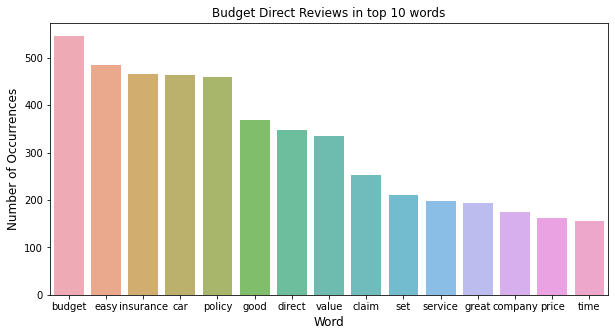

In [ ]:
# Visualize the top word counts in Budget Direct
w_count_b = w_freq_b_direct[:15,]
#word_count = word_count[:15,]
plt.figure(figsize=(10,5))
sns.barplot(w_count_b.index, w_count_b.values, alpha=0.8)
plt.title('Budget Direct Reviews in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


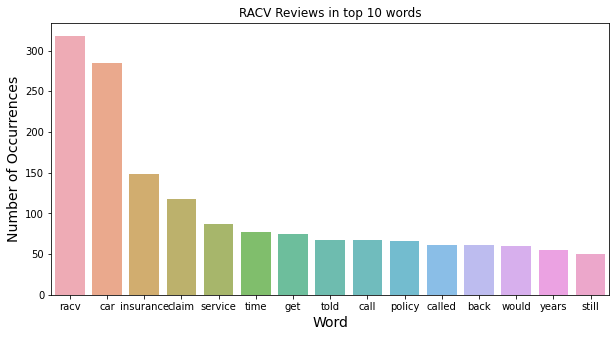

In [ ]:
# Visualize the top word counts in RACV
w_count_racv = w_freq_racv[:15,]
#word_count = word_count[:15,]
plt.figure(figsize=(10,5))
sns.barplot(w_count_racv.index, w_count_racv.values, alpha=0.8)
plt.title('RACV Reviews in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Word', fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


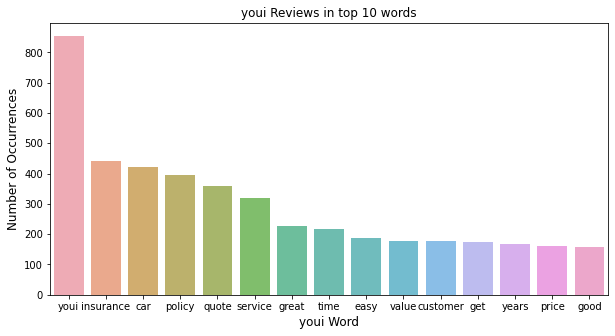

In [ ]:
# Visualize the top word counts in RACV
w_count_youi = w_freq_youi[:15,]
#word_count = word_count[:15,]
plt.figure(figsize=(10,5))
sns.barplot(w_count_youi.index, w_count_youi.values, alpha=0.8)
plt.title('youi Reviews in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('youi Word', fontsize=12)
plt.show()

***Visvalizing the Text Corpus***

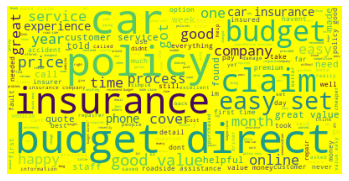

In [ ]:
from PIL import Image
from wordcloud import WordCloud
text_corpus = list(b_direct1['review'])
w_clouds = WordCloud(background_color='yellow', max_words=200, max_font_size=50, random_state=42).generate(str(text_corpus))

fig = plt.figure(1)
plt.imshow(w_clouds)
plt.axis('off')
plt.show()

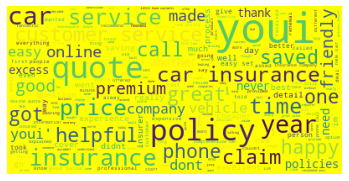

In [ ]:
text_corpus1 = list(youi_new['review'])
w_cloud1 = WordCloud(background_color='yellow', max_words=200, max_font_size=50, random_state=42).generate(str(text_corpus1))

fig = plt.figure(2)
plt.imshow(w_cloud1)
plt.axis('off')
plt.show()

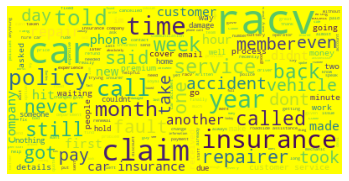

In [ ]:
text_corpus2 = list(racv_1['review'])
w_cloud2 = WordCloud(background_color='yellow', max_words=200, max_font_size=50, random_state=42).generate(str(text_corpus2))

fig = plt.figure(1)
plt.imshow(w_cloud2)
plt.axis('off')
plt.show()